In [ ]:
# Run this line in Colab to install the package if it is
# not already installed.
!pip install git+https://github.com/openai/glide-text2im

In [1]:
from PIL import Image
from IPython.display import display
import torch as th
import torch.nn as nn

from glide_text2im.clip.model_creation import create_clip_model
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler,
)
from glide_text2im.tokenizer.simple_tokenizer import SimpleTokenizer

In [2]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [3]:
# Create base model.
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385030726


In [4]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

total upsampler parameters 398361286


In [5]:

import json
import torch
import sys
sys.path.append('/notebooks/psangkloy3/open_clip/src/')
from clip.clip import tokenize
from clip.model import convert_weights, CLIP
model_config_file = '/notebooks/psangkloy3/open_clip/src/training/model_configs/ViT-B-16.json'
with open(model_config_file, 'r') as f:
    model_info = json.load(f)
        


In [6]:
#model = CLIP(**model_info)
#model_file ="/notebooks/psangkloy3/open_clip/logs/all_coco/lr=1e-05_wd=0.1_agg=True_model=ViT-B/16_weight_sharing=False_feature_fusion=avg_weight_cl=1_weight_tdl=10_batchsize=32_workers=1_date=2021-11-12-11-15-55/checkpoints/epoch_19.pt"

#loc = "cuda:{}".format(0)
#checkpoint = torch.load(model_file, map_location=loc)

#sd = checkpoint["state_dict"]
#if next(iter(sd.items()))[0].startswith('module'):
#    sd = {k[len('module.'):]: v for k, v in sd.items()}
#model.load_state_dict(sd, strict=False)

In [7]:
state_dict = th.load('min_skgclip_model.pth')

In [8]:
vision_width = state_dict["visual.conv1.weight"].shape[0]
vision_layers = len([k for k in state_dict.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
grid_size = round((state_dict["visual.positional_embedding"].shape[0] - 1) ** 0.5)
image_resolution = vision_patch_size * grid_size
vision_heads = vision_width // 64
embed_dim = state_dict["text_projection"].shape[1]
context_length = state_dict["positional_embedding"].shape[0]
vocab_size = state_dict["token_embedding.weight"].shape[0]
transformer_width = state_dict["ln_final.weight"].shape[0]
transformer_heads = transformer_width // 64
transformer_layers = len(set(k.split(".")[2] for k in state_dict if k.startswith(f"transformer.resblocks")))

In [9]:
from clip.model import VisualTransformer, LayerNorm, Transformer


In [10]:
import numpy as np
from typing import Tuple, Union

class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)
class minCLIP(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # text
                 context_length: int,
                 vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int,
                 ):
        super().__init__()
        self.context_length = context_length
        #set default to weight sharing
        #vision_heads = vision_width // 64
        self.visual =  VisualTransformer(image_resolution, vision_patch_size, vision_width, vision_layers, vision_heads,embed_dim)
        self.visual2  =  VisualTransformer(image_resolution, vision_patch_size, vision_width, vision_layers, vision_heads,embed_dim)
        self.transformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask()
        )

        transformer_width = 512
        embed_dim = 512
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(77, transformer_width))
        
        self.ln_final = LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.feature_fusion = 'avg'
       
    def build_attention_mask(self):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype
    
    def encode_image(self, image):
        return self.visual(image.type(self.dtype))
    def encode_sketch(self, image):
        return self.visual2(image.type(self.dtype))

    def encode_text(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x
    
    def feature_fuse(self, text_features, sketch_features):
        #mode = avg|max
        if self.feature_fusion == 'avg':
            fused_features = (text_features + sketch_features)/2
        elif self.feature_fusion == 'max':
            fused_features = torch.max(text_features,sketch_features)
        elif self.feature_fusion == 'skg':
            fused_features = sketch_features
        elif self.feature_fusion=='txt':
            fused_features = text_features
        else:
            raise Exception(f'Mode {self.feature_fusion} not yet supported')
        return fused_features
   
    def forward(self, image, text, sketch):
       
        #dummy forward
        
        return None

   
clip_model = minCLIP(
        embed_dim,
        image_resolution, vision_layers, vision_width, vision_patch_size,
        context_length, vocab_size, transformer_width, transformer_heads, transformer_layers
    )

In [11]:
for key in ["input_resolution", "context_length", "vocab_size"]:
    if key in state_dict:
        del state_dict[key]
convert_weights(clip_model)

In [12]:
clip_model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [13]:
#### import os
from functools import lru_cache
from typing import Any, Callable, Dict, List, Optional, Tuple

import attr
import numpy as np
import torch
import torch.nn as nn
import yaml
from glide_text2im.tokenizer.simple_tokenizer import SimpleTokenizer
import torch.nn.functional as F

@attr.s
class SKGCLIPModel:
    config: Dict[str, Any] = attr.ib()
    logit_scale: torch.Tensor = attr.ib()
    device: torch.device = attr.ib()
    model: CLIP = attr.ib()

    def text_embeddings(self, prompts: List[str]) -> torch.Tensor:
        #tokens, lens = model.encode_text()#
        #self.encode_prompts(prompts)
        txt = tokenize(prompts).cuda()
        z_t = self.model.encode_text(txt)#self.text_encoder(tokens, lens)
        return z_t / (torch.linalg.norm(z_t, dim=-1, keepdim=True) + 1e-12)

    def image_embeddings(self, images: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        #z_i = self.image_encoder((images + 1) * 127.5, t)
        z_i = self.model.encode_image(images)
        return z_i / (torch.linalg.norm(z_i, dim=-1, keepdim=True) + 1e-12)
    
    def sketch_embeddings(self, images: torch.Tensor) -> torch.Tensor:
        #z_i = self.image_encoder((images + 1) * 127.5, t)
        z_i = self.model.encode_sketch(images)
        return z_i / (torch.linalg.norm(z_i, dim=-1, keepdim=True) + 1e-12)

    def cond_fn(self, prompts: List[str], grad_scale: float, sketch: torch.Tensor, ratio: int = 0.5) -> Callable[..., torch.Tensor]:
        with torch.no_grad():
            z_t = self.text_embeddings(prompts)
            z_s = self.sketch_embeddings(sketch.unsqueeze(0))
            z = self.model.feature_fuse(z_t, z_s)
        assert ratio <= 1 and ratio >=0
        def cond_fn(x, t, grad_scale=grad_scale, **kwargs):
            with torch.enable_grad():
                x_var = x.detach().requires_grad_(True)
                
                #upsampling
                x_var_ = F.interpolate(x_var, size=image_resolution)
                
                z_i = self.image_embeddings(x_var_, t)
                
                loss = torch.exp(self.logit_scale) * (z * z_i).sum() #(1-ratio)*torch.exp(self.logit_scale) * (z_t * z_i).sum() + (ratio)*(z_s - z_i).pow(2).sum().sqrt()
                print('\rLoss:'+ str(loss.item()), end="")
                grad = torch.autograd.grad(loss, x_var)[0].detach()
            return grad * grad_scale

        return cond_fn

In [14]:
skgclip_model =  SKGCLIPModel(model_info, clip_model.logit_scale, 'cuda', clip_model.cuda())

In [15]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

In [16]:
#from pathlib import Path
#SKETCH_PATH = Path('../../cvpr2022_supp/sketches/')
#sketch_list = [x for x in SKETCH_PATH.glob('*')]
#sketch_path = str(np.random.choice(sketch_list))
#sketch = Image.open(sketch_path)
#sketch

In [17]:
from clip.clip import _transform, load
preprocess_val = _transform(clip_model.visual.input_resolution, is_train=False)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [18]:
# Sampling parameters
prompt = "a rabbit in a field."
batch_size = 1
guidance_scale = 3.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

  0%|          | 0/100 [00:00<?, ?it/s]

Loss:17.249044418334964

  0%|          | 0/27 [00:00<?, ?it/s]

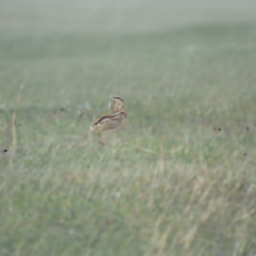

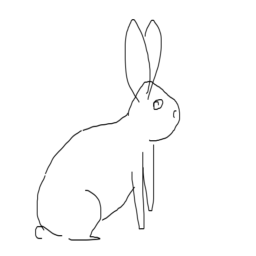

  0%|          | 0/100 [00:00<?, ?it/s]

Loss:41.212154388427734

  0%|          | 0/27 [00:00<?, ?it/s]

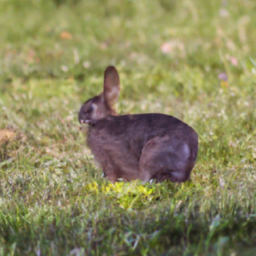

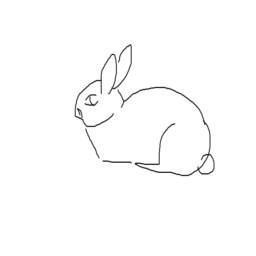

  0%|          | 0/100 [00:00<?, ?it/s]

Loss:34.083038330078125

  0%|          | 0/27 [00:00<?, ?it/s]

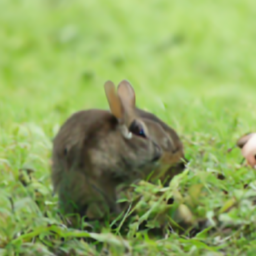

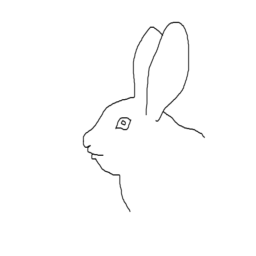

In [20]:
files = ['n02325366_1088-3.png', 'n02325366_1084-5.png', 'n02325366_10935-2.png']
#files = [sketch_path]
sketches = [Image.open(x) for x in files]
for sketch in sketches:
    #sketch = Image.open('n02691156_10504-3.png')
    ##############################
    # Sample from the base model #
    ##############################

    # Create the text tokens to feed to the model.
    tokens = model.tokenizer.encode(prompt)
    tokens, mask = model.tokenizer.padded_tokens_and_mask(
        tokens, options['text_ctx']
    )

    # Pack the tokens together into model kwargs.
    model_kwargs = dict(
        tokens=th.tensor([tokens] * batch_size, device=device),
        mask=th.tensor([mask] * batch_size, dtype=th.bool, device=device),
    )

    # Setup guidance function for CLIP model.
    cond_fn = skgclip_model.cond_fn([prompt] * batch_size, guidance_scale, preprocess_val(sketch).cuda(), 1)

    # Sample from the base model.
    model.del_cache()
    samples = diffusion.p_sample_loop(
        model,
        (batch_size, 3, options["image_size"], options["image_size"]),
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=cond_fn,
    )
    model.del_cache()

    # Show the output
    #show_images(samples)

    ##############################
    # Upsample the 64x64 samples #
    ##############################

    tokens = model_up.tokenizer.encode(prompt)
    tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
        tokens, options_up['text_ctx']
    )

    # Create the model conditioning dict.
    model_kwargs = dict(
        # Low-res image to upsample.
        low_res=((samples+1)*127.5).round()/127.5 - 1,

        # Text tokens
        tokens=th.tensor(
            [tokens] * batch_size, device=device
        ),
        mask=th.tensor(
            [mask] * batch_size,
            dtype=th.bool,
            device=device,
        ),
    )

    # Sample from the base model.
    model_up.del_cache()
    up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
    up_samples = diffusion_up.ddim_sample_loop(
        model_up,
        up_shape,
        noise=th.randn(up_shape, device=device) * upsample_temp,
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
    model_up.del_cache()

    # Show the output
    show_images(up_samples)
    display(sketch)